<a href="https://colab.research.google.com/github/Swamydoss-k/Low-code-AI-book-projects/blob/main/GAN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
device ='cuda'


In [ ]:
#visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  #tensor = 128 X 724 which is (28*28)
  data=tensor.detach().cpu().view(-1,ch,*size) #128*1* 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show

In [ ]:
#setup Parameters and Hyperparameters
epochs =500
cur_step=0
info_step=300
mean_gen_loss = 0
mean_dic_loss = 0
z_dim = 64
lr=0.00001
loss_func = nn.BCEWithLogitsLoss()
bs=128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(MNIST('.', download =True, transform = transforms.ToTensor()), shuffle = True, batch_size=bs)

In [ ]:
#generator block
def genBlock(inp, out):
  return nn.Sequential(
    nn.Linear(inp, out),
    nn.BatchNorm1d(out),
    nn.ReLU(inplace=True)

  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim),
        genBlock(h_dim, h_dim*2),
        genBlock(h_dim*2, h_dim*4),
        genBlock(h_dim*4, h_dim*8),
        nn.Linear(h_dim*8, i_dim),
        nn.Sigmoid(),
    )

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

In [ ]:
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)

  )
class Discriminiator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4),
        discBlock(h_dim*4, h_dim*2),
        discBlock(h_dim*2, h_dim),
        nn.Linear(h_dim, 1)
    )
  def forward(self, image):
    return self.disc(image)

In [ ]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(), lr=lr)
disc=Discriminiator()
dis_opt=torch.optim.Adam(disc.parameters(), lr=lr)



In [ ]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])


torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 4, 7, 1, 2, 2, 0, 6, 7, 1])


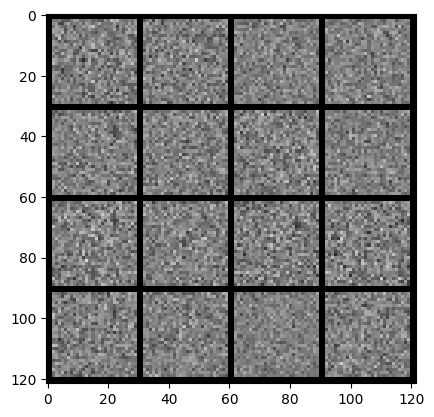

In [ ]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
#calculate the loss
#generator loss

def cal_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake_img = gen(noise)
  pred = disc(fake_img)
  targets=torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)
  return gen_loss

def cal_disc_loss(loss_func, gen, disc, real, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake_img = gen(noise)
  pred_fake = disc(fake_img.detach())
  pred_fake_loss = loss_func(pred_fake, torch.zeros_like(pred_fake))

  pred_real = disc(real)
  pred_real_loss = loss_func(pred_real, torch.ones_like(pred_real))
  dis_loss = (pred_fake_loss + pred_real_loss)/2
  return dis_loss


In [ ]:
for epoc in range(epochs):
  for real, _ in tqdm(dataloader):
    ##discriminator
    dis_opt.zero_grad()
    cur_batch_size = len(real)

    real = real.view(cur_batch_size, -1).to(device)
    #disc_opt.zero_grad()
    disc_loss = cal_disc_loss(loss_func, gen.to(device), disc.to(device), real, cur_batch_size, z_dim)
    disc_loss.backward(retain_graph=True)
    dis_opt.step()

    ##generator
    gen_opt.zero_grad()
    gen_loss = cal_gen_loss(loss_func, gen, disc, cur_batch_size, z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    #visualization
    mean_disc_loss =0
    mean_gen_loss=0
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_batch_size, z_dim)
      fake = gen(fake_noise)
      show(fake)
      #show(fake)
      show(real)
      print(f"Step {cur_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}")
      mean_gen_loss=0
      mean_disc_loss=0
    cur_step+=1

  0%|          | 0/469 [00:00<?, ?it/s]

Step 300: Generator loss: 0.011441491444905598, Discriminator loss: 0.00047069753209749856


  0%|          | 0/469 [00:00<?, ?it/s]

Step 600: Generator loss: 0.011094341278076172, Discriminator loss: 0.0002644197642803192
Step 900: Generator loss: 0.010448421637217204, Discriminator loss: 0.00015580977002779643


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1200: Generator loss: 0.011027844746907552, Discriminator loss: 0.00015374816954135894


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.01135224183400472, Discriminator loss: 0.00013171908756097158
Step 1800: Generator loss: 0.012111984093983967, Discriminator loss: 0.00011140387505292892


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2100: Generator loss: 0.013198477427164713, Discriminator loss: 0.0001660872499148051


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2400: Generator loss: 0.014039144515991211, Discriminator loss: 0.00011952541768550873
Step 2700: Generator loss: 0.016108942031860352, Discriminator loss: 7.406598577896755e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.016145296096801758, Discriminator loss: 9.680715079108875e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3300: Generator loss: 0.018614892959594728, Discriminator loss: 4.3567592899004616e-05
Step 3600: Generator loss: 0.01932126045227051, Discriminator loss: 4.594349612792333e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3900: Generator loss: 0.018199071884155274, Discriminator loss: 5.258663867910703e-05
Step 4200: Generator loss: 0.019358994166056315, Discriminator loss: 2.9079467058181763e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.020197121302286784, Discriminator loss: 7.61812428633372e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4800: Generator loss: 0.022051865259806316, Discriminator loss: 2.2589067618052166e-05
Step 5100: Generator loss: 0.021567029953002928, Discriminator loss: 2.458497881889343e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5400: Generator loss: 0.021559077898661294, Discriminator loss: 1.6865705450375875e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5700: Generator loss: 0.020791368484497072, Discriminator loss: 2.8914380818605425e-05
Step 6000: Generator loss: 0.022086346944173177, Discriminator loss: 4.901320673525333e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6300: Generator loss: 0.024074535369873046, Discriminator loss: 2.9690920685728393e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6600: Generator loss: 0.022386020024617512, Discriminator loss: 2.4524444403747716e-05
Step 6900: Generator loss: 0.02334699312845866, Discriminator loss: 3.0998199557264644e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7200: Generator loss: 0.020899845759073894, Discriminator loss: 8.016493171453476e-05
Step 7500: Generator loss: 0.02388211409250895, Discriminator loss: 2.9465171198050182e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7800: Generator loss: 0.02222790559132894, Discriminator loss: 1.986254472285509e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8100: Generator loss: 0.024562819798787435, Discriminator loss: 3.2340449591477713e-05
Step 8400: Generator loss: 0.022919712066650392, Discriminator loss: 4.6733571216464043e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8700: Generator loss: 0.022899316151936848, Discriminator loss: 4.5279584204157196e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.02480417728424072, Discriminator loss: 1.720890402793884e-05
Step 9300: Generator loss: 0.022697594960530598, Discriminator loss: 9.680387874444326e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9600: Generator loss: 0.02473936398824056, Discriminator loss: 7.776341711481412e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9900: Generator loss: 0.025360713005065916, Discriminator loss: 2.6497434203823406e-05
Step 10200: Generator loss: 0.021626014709472657, Discriminator loss: 1.628556133558353e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.023234856923421223, Discriminator loss: 2.172107963512341e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10800: Generator loss: 0.023150266011555988, Discriminator loss: 6.076107422510783e-05
Step 11100: Generator loss: 0.02281247138977051, Discriminator loss: 5.031165666878224e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11400: Generator loss: 0.024773941040039063, Discriminator loss: 2.735690213739872e-05
Step 11700: Generator loss: 0.024712905883789063, Discriminator loss: 3.8163096954425174e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.020048583348592122, Discriminator loss: 0.00019806534051895142


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12300: Generator loss: 0.02356863021850586, Discriminator loss: 2.2711198156078656e-05
Step 12600: Generator loss: 0.025815982818603516, Discriminator loss: 0.00010704066604375839


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12900: Generator loss: 0.01963349183400472, Discriminator loss: 8.933406323194504e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13200: Generator loss: 0.01929255485534668, Discriminator loss: 9.844637165466944e-05
Step 13500: Generator loss: 0.02433726628621419, Discriminator loss: 0.00011376352359851202


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13800: Generator loss: 0.02376378377278646, Discriminator loss: 7.496056457360586e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14100: Generator loss: 0.023027178446451822, Discriminator loss: 4.0000869582096736e-05
Step 14400: Generator loss: 0.024198158582051595, Discriminator loss: 2.9598871866861978e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14700: Generator loss: 0.02185960133870443, Discriminator loss: 4.718966782093048e-05
Step 15000: Generator loss: 0.02135310967763265, Discriminator loss: 7.703098778923352e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15300: Generator loss: 0.020441792805989584, Discriminator loss: 9.321574742595355e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15600: Generator loss: 0.019420806566874185, Discriminator loss: 6.694347908099493e-05
Step 15900: Generator loss: 0.023119872411092122, Discriminator loss: 6.448982904354731e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16200: Generator loss: 0.020373682975769043, Discriminator loss: 5.242118611931801e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.02148391882578532, Discriminator loss: 5.823962390422821e-05
Step 16800: Generator loss: 0.019266268412272136, Discriminator loss: 8.710435902078947e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17100: Generator loss: 0.018901828130086264, Discriminator loss: 5.618758499622345e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17400: Generator loss: 0.02426302433013916, Discriminator loss: 3.1793247908353804e-05
Step 17700: Generator loss: 0.02103009541829427, Discriminator loss: 0.00012513647476832072


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.022193140983581543, Discriminator loss: 8.545571317275366e-05


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18300: Generator loss: 0.02280014514923096, Discriminator loss: 0.00014989340056975682
Step 18600: Generator loss: 0.018518271446228026, Discriminator loss: 0.00011517986655235291


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18900: Generator loss: 0.019344210624694824, Discriminator loss: 6.0433192799488704e-05
Step 19200: Generator loss: 0.016701364517211915, Discriminator loss: 0.00012630203117926917


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.020026602745056153, Discriminator loss: 0.0001226248840490977


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19800: Generator loss: 0.017776943842569986, Discriminator loss: 8.824593077103297e-05
Step 20100: Generator loss: 0.020487507184346516, Discriminator loss: 0.00014702975749969482


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20400: Generator loss: 0.02153222401936849, Discriminator loss: 0.00011675506830215454


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20700: Generator loss: 0.01668409983317057, Discriminator loss: 0.00037924036383628844
Step 21000: Generator loss: 0.01222303549448649, Discriminator loss: 0.00018717922270298004


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21300: Generator loss: 0.016819918950398763, Discriminator loss: 0.0002820407102505366


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21600: Generator loss: 0.016853559811909995, Discriminator loss: 0.00041322489579518636
Step 21900: Generator loss: 0.017021466890970866, Discriminator loss: 0.000248756135503451


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22200: Generator loss: 0.016098663012186685, Discriminator loss: 0.0002681198219458262
Step 22500: Generator loss: 0.01611569881439209, Discriminator loss: 0.00023275136947631836


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22800: Generator loss: 0.011827843983968099, Discriminator loss: 0.00016663122922182084


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23100: Generator loss: 0.013279239336649576, Discriminator loss: 0.00022772952914237976
Step 23400: Generator loss: 0.014198939005533854, Discriminator loss: 0.00017885472625494002


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23700: Generator loss: 0.014444777170817057, Discriminator loss: 0.0002590727557738622


  0%|          | 0/469 [00:00<?, ?it/s]

Step 24000: Generator loss: 0.018237016995747885, Discriminator loss: 0.00020583484321832658
Step 24300: Generator loss: 0.014815783500671387, Discriminator loss: 0.00033919364213943484


  0%|          | 0/469 [00:00<?, ?it/s]

Step 24600: Generator loss: 0.015699659983317057, Discriminator loss: 0.0002558596432209015


  0%|          | 0/469 [00:00<?, ?it/s]

Step 24900: Generator loss: 0.013453763326009114, Discriminator loss: 0.00028699758152167
Step 25200: Generator loss: 0.016573432286580404, Discriminator loss: 0.0002353350321451823


  0%|          | 0/469 [00:00<?, ?it/s]

Step 25500: Generator loss: 0.01306813398996989, Discriminator loss: 0.0004183803002039592


  0%|          | 0/469 [00:00<?, ?it/s]

Step 25800: Generator loss: 0.015019222895304362, Discriminator loss: 0.00021551852424939473
Step 26100: Generator loss: 0.013727200826009115, Discriminator loss: 0.00017881454279025395


  0%|          | 0/469 [00:00<?, ?it/s]

Step 26400: Generator loss: 0.01662720203399658, Discriminator loss: 0.00018308072040478388
Step 26700: Generator loss: 0.013346891403198242, Discriminator loss: 0.00023414013286431631


  0%|          | 0/469 [00:00<?, ?it/s]

Step 27000: Generator loss: 0.013419122695922851, Discriminator loss: 0.0004981837670008342


  0%|          | 0/469 [00:00<?, ?it/s]

Step 27300: Generator loss: 0.014167798360188803, Discriminator loss: 0.0003420134882132212
Step 27600: Generator loss: 0.016093111038208006, Discriminator loss: 0.00017902397861083348


  0%|          | 0/469 [00:00<?, ?it/s]

Step 27900: Generator loss: 0.015209075609842936, Discriminator loss: 0.00021681415537993113


  0%|          | 0/469 [00:00<?, ?it/s]

Step 28200: Generator loss: 0.01323043425877889, Discriminator loss: 0.0004582594335079193
Step 28500: Generator loss: 0.014266570409138998, Discriminator loss: 0.0004714966317017873


  0%|          | 0/469 [00:00<?, ?it/s]

Step 28800: Generator loss: 0.01258811871210734, Discriminator loss: 0.000526506503423055


  0%|          | 0/469 [00:00<?, ?it/s]

Step 29100: Generator loss: 0.015394822756449381, Discriminator loss: 0.00028926831980546317
Step 29400: Generator loss: 0.015125622749328613, Discriminator loss: 0.00033901398380597434


  0%|          | 0/469 [00:00<?, ?it/s]

Step 29700: Generator loss: 0.015958059628804526, Discriminator loss: 0.00024129405617713927
Step 30000: Generator loss: 0.015145877202351887, Discriminator loss: 0.0001831678549448649


  0%|          | 0/469 [00:00<?, ?it/s]

Step 30300: Generator loss: 0.014483496348063151, Discriminator loss: 0.00022934531172116596


  0%|          | 0/469 [00:00<?, ?it/s]

Step 30600: Generator loss: 0.013511220614115397, Discriminator loss: 0.000540476938088735
Step 30900: Generator loss: 0.012370901107788086, Discriminator loss: 0.00040887705981731417


  0%|          | 0/469 [00:00<?, ?it/s]

Step 31200: Generator loss: 0.013648972511291504, Discriminator loss: 0.0004792763292789459


  0%|          | 0/469 [00:00<?, ?it/s]

Step 31500: Generator loss: 0.012055359681447346, Discriminator loss: 0.0002465340991814931
Step 31800: Generator loss: 0.012146525382995606, Discriminator loss: 0.00019073632856210073


  0%|          | 0/469 [00:00<?, ?it/s]

Step 32100: Generator loss: 0.01376225471496582, Discriminator loss: 0.00046792050202687583


  0%|          | 0/469 [00:00<?, ?it/s]

Step 32400: Generator loss: 0.013357043266296387, Discriminator loss: 0.0002768462896347046
Step 32700: Generator loss: 0.013942979176839192, Discriminator loss: 0.00041193331281344096


  0%|          | 0/469 [00:00<?, ?it/s]

Step 33000: Generator loss: 0.014615357716878255, Discriminator loss: 0.0003639726092418035


  0%|          | 0/469 [00:00<?, ?it/s]

Step 33300: Generator loss: 0.015528513590494791, Discriminator loss: 0.00041627854108810424
Step 33600: Generator loss: 0.010283737182617188, Discriminator loss: 0.0002989951769510905


  0%|          | 0/469 [00:00<?, ?it/s]

Step 33900: Generator loss: 0.010569470723470052, Discriminator loss: 0.0006192855040232341
Step 34200: Generator loss: 0.012550722757975261, Discriminator loss: 0.000537643035252889


  0%|          | 0/469 [00:00<?, ?it/s]

Step 34500: Generator loss: 0.013121589819590251, Discriminator loss: 0.0002643150836229324


  0%|          | 0/469 [00:00<?, ?it/s]

Step 34800: Generator loss: 0.013805007934570313, Discriminator loss: 0.0004463677108287811
Step 35100: Generator loss: 0.014801208178202312, Discriminator loss: 0.0005115587015946707


  0%|          | 0/469 [00:00<?, ?it/s]

Step 35400: Generator loss: 0.012858157157897948, Discriminator loss: 0.00046947757403055827


  0%|          | 0/469 [00:00<?, ?it/s]

Step 35700: Generator loss: 0.013557607332865398, Discriminator loss: 0.0003951561947663625
Step 36000: Generator loss: 0.012553135553995768, Discriminator loss: 0.0004210334022839864


  0%|          | 0/469 [00:00<?, ?it/s]

Step 36300: Generator loss: 0.01296920379002889, Discriminator loss: 0.0005649150411287943


  0%|          | 0/469 [00:00<?, ?it/s]

Step 36600: Generator loss: 0.015426383018493653, Discriminator loss: 0.00047051707903544106
Step 36900: Generator loss: 0.01221461296081543, Discriminator loss: 0.000619063675403595


  0%|          | 0/469 [00:00<?, ?it/s]

Step 37200: Generator loss: 0.014766050974527994, Discriminator loss: 0.0005266611278057098
Step 37500: Generator loss: 0.013426567713419596, Discriminator loss: 0.0002792389194170634


  0%|          | 0/469 [00:00<?, ?it/s]

Step 37800: Generator loss: 0.01323935588200887, Discriminator loss: 0.0005269750952720642


  0%|          | 0/469 [00:00<?, ?it/s]

Step 38100: Generator loss: 0.012853291034698486, Discriminator loss: 0.0002845412989457448
Step 38400: Generator loss: 0.012996678352355956, Discriminator loss: 0.00043777093291282656


  0%|          | 0/469 [00:00<?, ?it/s]

Step 38700: Generator loss: 0.011683672269185385, Discriminator loss: 0.00026469131310780846


  0%|          | 0/469 [00:00<?, ?it/s]

Step 39000: Generator loss: 0.011189767519632975, Discriminator loss: 0.000485009104013443
Step 39300: Generator loss: 0.012744245529174804, Discriminator loss: 0.000394405797123909


  0%|          | 0/469 [00:00<?, ?it/s]

Step 39600: Generator loss: 0.01198734442392985, Discriminator loss: 0.00046467393636703494


  0%|          | 0/469 [00:00<?, ?it/s]

Step 39900: Generator loss: 0.013796753883361816, Discriminator loss: 0.0007150761783123016
Step 40200: Generator loss: 0.010317110220591227, Discriminator loss: 0.0004849026600519816


  0%|          | 0/469 [00:00<?, ?it/s]

Step 40500: Generator loss: 0.01193139394124349, Discriminator loss: 0.0005923948188622793
Step 40800: Generator loss: 0.01135583241780599, Discriminator loss: 0.0004278768102327983


  0%|          | 0/469 [00:00<?, ?it/s]

Step 41100: Generator loss: 0.012238251368204752, Discriminator loss: 0.0005680550634860992


  0%|          | 0/469 [00:00<?, ?it/s]

Step 41400: Generator loss: 0.010972212155659994, Discriminator loss: 0.0008954770366350809
Step 41700: Generator loss: 0.01250057299931844, Discriminator loss: 0.0006432632605234782


  0%|          | 0/469 [00:00<?, ?it/s]

Step 42000: Generator loss: 0.012557627360026042, Discriminator loss: 0.0003795931984980901


  0%|          | 0/469 [00:00<?, ?it/s]

Step 42300: Generator loss: 0.012847514152526855, Discriminator loss: 0.0005559154848257701
Step 42600: Generator loss: 0.01180023988087972, Discriminator loss: 0.0003221661597490311


  0%|          | 0/469 [00:00<?, ?it/s]

Step 42900: Generator loss: 0.011269070307413738, Discriminator loss: 0.0007377101977666219


  0%|          | 0/469 [00:00<?, ?it/s]

Step 43200: Generator loss: 0.010951631863911947, Discriminator loss: 0.0005928126474221547
Step 43500: Generator loss: 0.010945310592651367, Discriminator loss: 0.0006080130239327748


  0%|          | 0/469 [00:00<?, ?it/s]

Step 43800: Generator loss: 0.013657636642456054, Discriminator loss: 0.0005936900774637858


  0%|          | 0/469 [00:00<?, ?it/s]

Step 44100: Generator loss: 0.011456356048583985, Discriminator loss: 0.000576331615447998
Step 44400: Generator loss: 0.013560034434000652, Discriminator loss: 0.00041761860251426697


  0%|          | 0/469 [00:00<?, ?it/s]

Step 44700: Generator loss: 0.010581642786661783, Discriminator loss: 0.0008240898450215657
Step 45000: Generator loss: 0.010139153003692628, Discriminator loss: 0.0004988081256548563


  0%|          | 0/469 [00:00<?, ?it/s]

Step 45300: Generator loss: 0.01097201426823934, Discriminator loss: 0.0005922800302505493


  0%|          | 0/469 [00:00<?, ?it/s]

Step 45600: Generator loss: 0.009571572144826254, Discriminator loss: 0.0008702176809310913
Step 45900: Generator loss: 0.009442541599273682, Discriminator loss: 0.0008860147992769877


  0%|          | 0/469 [00:00<?, ?it/s]

Step 46200: Generator loss: 0.009830660820007324, Discriminator loss: 0.0005041715999444325


  0%|          | 0/469 [00:00<?, ?it/s]

Step 46500: Generator loss: 0.012123862107594807, Discriminator loss: 0.0005418270826339722
Step 46800: Generator loss: 0.009862321217854818, Discriminator loss: 0.0007601370910803477


  0%|          | 0/469 [00:00<?, ?it/s]

Step 47100: Generator loss: 0.01103859265645345, Discriminator loss: 0.0005513244867324829


  0%|          | 0/469 [00:00<?, ?it/s]

Step 47400: Generator loss: 0.011337049007415771, Discriminator loss: 0.0006059739987055461
Step 47700: Generator loss: 0.011457075277964274, Discriminator loss: 0.0007792499661445618


  0%|          | 0/469 [00:00<?, ?it/s]

Step 48000: Generator loss: 0.010136987368265788, Discriminator loss: 0.0005530135333538056
Step 48300: Generator loss: 0.011405177116394043, Discriminator loss: 0.0007060545682907104


  0%|          | 0/469 [00:00<?, ?it/s]

Step 48600: Generator loss: 0.009518998463948568, Discriminator loss: 0.000695291260878245


  0%|          | 0/469 [00:00<?, ?it/s]

Step 48900: Generator loss: 0.009094821612040201, Discriminator loss: 0.0006909984350204468
Step 49200: Generator loss: 0.012448023160298666, Discriminator loss: 0.00040882185101509094


  0%|          | 0/469 [00:00<?, ?it/s]

Step 49500: Generator loss: 0.009963537057240804, Discriminator loss: 0.00079653928677241


  0%|          | 0/469 [00:00<?, ?it/s]

Step 49800: Generator loss: 0.009029262065887451, Discriminator loss: 0.0006858447194099427
Step 50100: Generator loss: 0.012046341101328533, Discriminator loss: 0.0006220680475234985


  0%|          | 0/469 [00:00<?, ?it/s]

Step 50400: Generator loss: 0.012177572250366211, Discriminator loss: 0.0006856231888135274


  0%|          | 0/469 [00:00<?, ?it/s]

Step 50700: Generator loss: 0.01071206569671631, Discriminator loss: 0.0004713582992553711
Step 51000: Generator loss: 0.00937353769938151, Discriminator loss: 0.000643192728360494


  0%|          | 0/469 [00:00<?, ?it/s]

Step 51300: Generator loss: 0.008587307929992676, Discriminator loss: 0.0005388966202735901


  0%|          | 0/469 [00:00<?, ?it/s]

Step 51600: Generator loss: 0.00749353567759196, Discriminator loss: 0.0007226074735323588
Step 51900: Generator loss: 0.009172180493672688, Discriminator loss: 0.0005051116645336151


  0%|          | 0/469 [00:00<?, ?it/s]

Step 52200: Generator loss: 0.008482457796732585, Discriminator loss: 0.0006678865353266398
Step 52500: Generator loss: 0.008886010646820068, Discriminator loss: 0.0008010570704936981


  0%|          | 0/469 [00:00<?, ?it/s]

Step 52800: Generator loss: 0.01054931640625, Discriminator loss: 0.0006684412558873495


  0%|          | 0/469 [00:00<?, ?it/s]

Step 53100: Generator loss: 0.009793188571929932, Discriminator loss: 0.0007127350568771362
Step 53400: Generator loss: 0.009024081230163574, Discriminator loss: 0.000711643397808075


  0%|          | 0/469 [00:00<?, ?it/s]

Step 53700: Generator loss: 0.010122981071472168, Discriminator loss: 0.0004942073921362558


  0%|          | 0/469 [00:00<?, ?it/s]

Step 54000: Generator loss: 0.009752232233683268, Discriminator loss: 0.0006773311893145243
Step 54300: Generator loss: 0.009504222869873047, Discriminator loss: 0.0007026222348213196


  0%|          | 0/469 [00:00<?, ?it/s]

Step 54600: Generator loss: 0.009430425961812337, Discriminator loss: 0.0007180336614449819


  0%|          | 0/469 [00:00<?, ?it/s]

Step 54900: Generator loss: 0.010099421342213949, Discriminator loss: 0.0009377167622248332
Step 55200: Generator loss: 0.010107518037160238, Discriminator loss: 0.0008350242177645365


  0%|          | 0/469 [00:00<?, ?it/s]

Step 55500: Generator loss: 0.009067912101745606, Discriminator loss: 0.0006169570485750834
Step 55800: Generator loss: 0.007980104287465413, Discriminator loss: 0.0008149924874305725


  0%|          | 0/469 [00:00<?, ?it/s]

Step 56100: Generator loss: 0.009136795997619629, Discriminator loss: 0.0007155926028887431


  0%|          | 0/469 [00:00<?, ?it/s]

Step 56400: Generator loss: 0.007304797172546387, Discriminator loss: 0.0008009648323059082
Step 56700: Generator loss: 0.00862523635228475, Discriminator loss: 0.0007315836350123087


  0%|          | 0/469 [00:00<?, ?it/s]

Step 57000: Generator loss: 0.009465498129526774, Discriminator loss: 0.0008671181400616963


  0%|          | 0/469 [00:00<?, ?it/s]

Step 57300: Generator loss: 0.007904541492462159, Discriminator loss: 0.0008519364396731058
Step 57600: Generator loss: 0.00927196502685547, Discriminator loss: 0.000959043800830841


  0%|          | 0/469 [00:00<?, ?it/s]

Step 57900: Generator loss: 0.007879220644632975, Discriminator loss: 0.0008546135822931926


  0%|          | 0/469 [00:00<?, ?it/s]

Step 58200: Generator loss: 0.010203890800476074, Discriminator loss: 0.0008539160092671713
Step 58500: Generator loss: 0.008515068689982096, Discriminator loss: 0.0007897071043650309


  0%|          | 0/469 [00:00<?, ?it/s]

Step 58800: Generator loss: 0.00953213612238566, Discriminator loss: 0.0005398507416248321


  0%|          | 0/469 [00:00<?, ?it/s]

Step 59100: Generator loss: 0.008607401053110758, Discriminator loss: 0.0008449597160021464
Step 59400: Generator loss: 0.007839318911234537, Discriminator loss: 0.0010257535179456075


  0%|          | 0/469 [00:00<?, ?it/s]

Step 59700: Generator loss: 0.009680032730102539, Discriminator loss: 0.0007953683535257976
Step 60000: Generator loss: 0.00665609876314799, Discriminator loss: 0.0006509420275688172


  0%|          | 0/469 [00:00<?, ?it/s]

Step 60300: Generator loss: 0.009021635055541993, Discriminator loss: 0.0006812064349651336


  0%|          | 0/469 [00:00<?, ?it/s]

Step 60600: Generator loss: 0.007678929169972737, Discriminator loss: 0.0007600375513235728
Step 60900: Generator loss: 0.008694318135579427, Discriminator loss: 0.0006399175028006236


  0%|          | 0/469 [00:00<?, ?it/s]

Step 61200: Generator loss: 0.007515856424967448, Discriminator loss: 0.0006977920730908712


  0%|          | 0/469 [00:00<?, ?it/s]

Step 61500: Generator loss: 0.009127880732218424, Discriminator loss: 0.0008396992087364197
Step 61800: Generator loss: 0.007723116874694824, Discriminator loss: 0.000884143610795339


  0%|          | 0/469 [00:00<?, ?it/s]

Step 62100: Generator loss: 0.008802572886149088, Discriminator loss: 0.0008505419890085857


  0%|          | 0/469 [00:00<?, ?it/s]

Step 62400: Generator loss: 0.00785534381866455, Discriminator loss: 0.0009019105633099874
Step 62700: Generator loss: 0.008265877564748128, Discriminator loss: 0.0007724914451440175


  0%|          | 0/469 [00:00<?, ?it/s]

Step 63000: Generator loss: 0.0073194742202758786, Discriminator loss: 0.0008368004361788432
Step 63300: Generator loss: 0.008285979429880777, Discriminator loss: 0.0006378708283106486


  0%|          | 0/469 [00:00<?, ?it/s]

Step 63600: Generator loss: 0.008472760518391928, Discriminator loss: 0.0007031673192977906


  0%|          | 0/469 [00:00<?, ?it/s]

Step 63900: Generator loss: 0.007290326754252116, Discriminator loss: 0.0010643349091211955
Step 64200: Generator loss: 0.0075010140736897785, Discriminator loss: 0.000926320751508077


  0%|          | 0/469 [00:00<?, ?it/s]

Step 64500: Generator loss: 0.007941859563191732, Discriminator loss: 0.0011065149307250978


  0%|          | 0/469 [00:00<?, ?it/s]

Step 64800: Generator loss: 0.009055489699045818, Discriminator loss: 0.0008847527702649435
Step 65100: Generator loss: 0.008048237959543864, Discriminator loss: 0.0010329284270604452


  0%|          | 0/469 [00:00<?, ?it/s]

Step 65400: Generator loss: 0.008587392965952555, Discriminator loss: 0.0011335663000742594


  0%|          | 0/469 [00:00<?, ?it/s]

Step 65700: Generator loss: 0.008795695304870605, Discriminator loss: 0.0008747400840123494
Step 66000: Generator loss: 0.008170056343078613, Discriminator loss: 0.000662687470515569


  0%|          | 0/469 [00:00<?, ?it/s]

Step 66300: Generator loss: 0.008614021937052409, Discriminator loss: 0.0008476921916007996


  0%|          | 0/469 [00:00<?, ?it/s]

Step 66600: Generator loss: 0.006464370886484782, Discriminator loss: 0.0012209810813268026
Step 66900: Generator loss: 0.0072766717274983725, Discriminator loss: 0.0011934028069178263


  0%|          | 0/469 [00:00<?, ?it/s]

Step 67200: Generator loss: 0.007367599805196127, Discriminator loss: 0.0009098591407140096
Step 67500: Generator loss: 0.008247694969177245, Discriminator loss: 0.0009413580099741618


  0%|          | 0/469 [00:00<?, ?it/s]

Step 67800: Generator loss: 0.008209413687388102, Discriminator loss: 0.0006700099507967631


  0%|          | 0/469 [00:00<?, ?it/s]

Step 68100: Generator loss: 0.008418946266174317, Discriminator loss: 0.0008226498961448669
Step 68400: Generator loss: 0.008484942118326823, Discriminator loss: 0.0007784746090571086


  0%|          | 0/469 [00:00<?, ?it/s]

Step 68700: Generator loss: 0.007064156532287598, Discriminator loss: 0.0011721006035804748


  0%|          | 0/469 [00:00<?, ?it/s]

Step 69000: Generator loss: 0.006901299953460694, Discriminator loss: 0.00101311723391215
Step 69300: Generator loss: 0.009353981018066407, Discriminator loss: 0.000785856048266093


  0%|          | 0/469 [00:00<?, ?it/s]

Step 69600: Generator loss: 0.008018169403076172, Discriminator loss: 0.0008042238652706147


  0%|          | 0/469 [00:00<?, ?it/s]

Step 69900: Generator loss: 0.007464810212453207, Discriminator loss: 0.0007351252933343251
Step 70200: Generator loss: 0.007373372713724772, Discriminator loss: 0.0009052732586860657


  0%|          | 0/469 [00:00<?, ?it/s]

Step 70500: Generator loss: 0.006688307126363119, Discriminator loss: 0.0007379897435506185
Step 70800: Generator loss: 0.006766375700632731, Discriminator loss: 0.001041784683863322


  0%|          | 0/469 [00:00<?, ?it/s]

Step 71100: Generator loss: 0.007847681045532226, Discriminator loss: 0.0007411981622378031


  0%|          | 0/469 [00:00<?, ?it/s]

Step 71400: Generator loss: 0.007673594156901041, Discriminator loss: 0.0009253982702891032
Step 71700: Generator loss: 0.006636247634887695, Discriminator loss: 0.0008701133728027344


  0%|          | 0/469 [00:00<?, ?it/s]

Step 72000: Generator loss: 0.006873222986857096, Discriminator loss: 0.0010644358396530152


  0%|          | 0/469 [00:00<?, ?it/s]

Step 72300: Generator loss: 0.008062413533528646, Discriminator loss: 0.0008401920398076376
Step 72600: Generator loss: 0.006553356647491455, Discriminator loss: 0.0011460405588150024


  0%|          | 0/469 [00:00<?, ?it/s]

Step 72900: Generator loss: 0.006657468477884928, Discriminator loss: 0.000853845477104187


  0%|          | 0/469 [00:00<?, ?it/s]

Step 73200: Generator loss: 0.007009310722351074, Discriminator loss: 0.000990603764851888
Step 73500: Generator loss: 0.009001242319742838, Discriminator loss: 0.0009869844714800516


  0%|          | 0/469 [00:00<?, ?it/s]

Step 73800: Generator loss: 0.007248379389444987, Discriminator loss: 0.0006326319773991903
Step 74100: Generator loss: 0.007750080426534017, Discriminator loss: 0.0009532153606414794


  0%|          | 0/469 [00:00<?, ?it/s]

Step 74400: Generator loss: 0.008110033671061197, Discriminator loss: 0.0008053629597028096


  0%|          | 0/469 [00:00<?, ?it/s]

Step 74700: Generator loss: 0.00807775100072225, Discriminator loss: 0.0005989623069763184
Step 75000: Generator loss: 0.0078184175491333, Discriminator loss: 0.0009281832973162333


  0%|          | 0/469 [00:00<?, ?it/s]

Step 75300: Generator loss: 0.007494494120279948, Discriminator loss: 0.0007684805492560069


  0%|          | 0/469 [00:00<?, ?it/s]

Step 75600: Generator loss: 0.007609680493672688, Discriminator loss: 0.0007588884234428406
Step 75900: Generator loss: 0.007809503873189291, Discriminator loss: 0.0007367650667826335


  0%|          | 0/469 [00:00<?, ?it/s]

Step 76200: Generator loss: 0.007509519259134928, Discriminator loss: 0.0009251287579536437


  0%|          | 0/469 [00:00<?, ?it/s]

Step 76500: Generator loss: 0.00734615961710612, Discriminator loss: 0.0009632756312688192
Step 76800: Generator loss: 0.007704819043477376, Discriminator loss: 0.0006916061043739319


  0%|          | 0/469 [00:00<?, ?it/s]

Step 77100: Generator loss: 0.006459046602249146, Discriminator loss: 0.001051085392634074


  0%|          | 0/469 [00:00<?, ?it/s]

Step 77400: Generator loss: 0.006212014357248942, Discriminator loss: 0.0010871999462445576
Step 77700: Generator loss: 0.00790391445159912, Discriminator loss: 0.0008244373401006063


  0%|          | 0/469 [00:00<?, ?it/s]

Step 78000: Generator loss: 0.007514123916625977, Discriminator loss: 0.0010565393169720968
Step 78300: Generator loss: 0.007460363705952962, Discriminator loss: 0.0008774985869725545


  0%|          | 0/469 [00:00<?, ?it/s]

Step 78600: Generator loss: 0.008897356192270915, Discriminator loss: 0.00102999081214269


  0%|          | 0/469 [00:00<?, ?it/s]

Step 78900: Generator loss: 0.0065854946772257485, Discriminator loss: 0.0008922823270161947
Step 79200: Generator loss: 0.005917996565500895, Discriminator loss: 0.0009748109181722005


  0%|          | 0/469 [00:00<?, ?it/s]

Step 79500: Generator loss: 0.0073524769147237145, Discriminator loss: 0.0010236941774686178


  0%|          | 0/469 [00:00<?, ?it/s]

Step 79800: Generator loss: 0.007639426390329997, Discriminator loss: 0.0008667616049448649
Step 80100: Generator loss: 0.00725762128829956, Discriminator loss: 0.0010072510441144307


  0%|          | 0/469 [00:00<?, ?it/s]

Step 80400: Generator loss: 0.007654150327046712, Discriminator loss: 0.0012531450390815735


  0%|          | 0/469 [00:00<?, ?it/s]

Step 80700: Generator loss: 0.006447834173838297, Discriminator loss: 0.0012013526757558186
Step 81000: Generator loss: 0.006969466209411621, Discriminator loss: 0.0007800127069155376


  0%|          | 0/469 [00:00<?, ?it/s]

Step 81300: Generator loss: 0.007325945695241292, Discriminator loss: 0.0009698820114135742
Step 81600: Generator loss: 0.008025779724121093, Discriminator loss: 0.0010057148337364197


  0%|          | 0/469 [00:00<?, ?it/s]

Step 81900: Generator loss: 0.005966937939325969, Discriminator loss: 0.0011506986618041992


  0%|          | 0/469 [00:00<?, ?it/s]

Step 82200: Generator loss: 0.0060373799006144205, Discriminator loss: 0.0010481258233388266
Step 82500: Generator loss: 0.006159673531850179, Discriminator loss: 0.0010489165782928468


  0%|          | 0/469 [00:00<?, ?it/s]

Step 82800: Generator loss: 0.00819046417872111, Discriminator loss: 0.000916153093179067


  0%|          | 0/469 [00:00<?, ?it/s]

Step 83100: Generator loss: 0.006678283214569092, Discriminator loss: 0.0010813115040461223
Step 83400: Generator loss: 0.006923468112945557, Discriminator loss: 0.0008724940816561381


  0%|          | 0/469 [00:00<?, ?it/s]

Step 83700: Generator loss: 0.007287372748057047, Discriminator loss: 0.0008487992485364278


  0%|          | 0/469 [00:00<?, ?it/s]

Step 84000: Generator loss: 0.0065169902642567955, Discriminator loss: 0.0009028335412343343
Step 84300: Generator loss: 0.006238709290822347, Discriminator loss: 0.0009539900223414103


  0%|          | 0/469 [00:00<?, ?it/s]

Step 84600: Generator loss: 0.006782172520955403, Discriminator loss: 0.001058146357536316


  0%|          | 0/469 [00:00<?, ?it/s]

Step 84900: Generator loss: 0.0071598656972249345, Discriminator loss: 0.0006776967147986094
Step 85200: Generator loss: 0.00656179666519165, Discriminator loss: 0.001167248288790385


  0%|          | 0/469 [00:00<?, ?it/s]

Step 85500: Generator loss: 0.006378595034281413, Discriminator loss: 0.0010154972473780314
Step 85800: Generator loss: 0.007207682927449544, Discriminator loss: 0.0011939001083374023


  0%|          | 0/469 [00:00<?, ?it/s]

Step 86100: Generator loss: 0.006796708106994629, Discriminator loss: 0.0010766072074572246


  0%|          | 0/469 [00:00<?, ?it/s]

Step 86400: Generator loss: 0.006034959554672242, Discriminator loss: 0.0011785151561101279
Step 86700: Generator loss: 0.006173470815022787, Discriminator loss: 0.0011782445510228475


  0%|          | 0/469 [00:00<?, ?it/s]

Step 87000: Generator loss: 0.005851477781931559, Discriminator loss: 0.001273253361384074


  0%|          | 0/469 [00:00<?, ?it/s]

Step 87300: Generator loss: 0.006532667875289917, Discriminator loss: 0.001085259517033895
Step 87600: Generator loss: 0.0060072390238444014, Discriminator loss: 0.001007718841234843


  0%|          | 0/469 [00:00<?, ?it/s]

Step 87900: Generator loss: 0.006522445678710937, Discriminator loss: 0.0011053253213564554


  0%|          | 0/469 [00:00<?, ?it/s]

Step 88200: Generator loss: 0.0063942837715148925, Discriminator loss: 0.0012829983234405517
Step 88500: Generator loss: 0.007013508478800456, Discriminator loss: 0.0009490841627120972


  0%|          | 0/469 [00:00<?, ?it/s]

Step 88800: Generator loss: 0.00663538376490275, Discriminator loss: 0.0010924458503723145
Step 89100: Generator loss: 0.006682633558909098, Discriminator loss: 0.0010185089707374572


  0%|          | 0/469 [00:00<?, ?it/s]

Step 89400: Generator loss: 0.006613266070683797, Discriminator loss: 0.0010548481345176697


  0%|          | 0/469 [00:00<?, ?it/s]

Step 89700: Generator loss: 0.0051254057884216305, Discriminator loss: 0.0010011707743008932
Step 90000: Generator loss: 0.005948957204818726, Discriminator loss: 0.0013205547134081523


  0%|          | 0/469 [00:00<?, ?it/s]

Step 90300: Generator loss: 0.0062672865390777585, Discriminator loss: 0.0011968901753425598


  0%|          | 0/469 [00:00<?, ?it/s]

Step 90600: Generator loss: 0.006562017599741618, Discriminator loss: 0.0011216266949971518
Step 90900: Generator loss: 0.007056409517923991, Discriminator loss: 0.000904025932153066


  0%|          | 0/469 [00:00<?, ?it/s]

Step 91200: Generator loss: 0.0054796059926350916, Discriminator loss: 0.0014670076966285706
